In [1]:
import re
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split

2024-04-12 12:51:21.332436: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 12:51:22.179685: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
txt_file = 'data/kor_rock_bigram.txt'
raw_corpus = []

with open(txt_file, 'r', encoding = 'utf-8') as f:
    raw = f.read().splitlines()
    raw_corpus.extend(raw)
print(len(raw_corpus))

191700


In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()                         #소문자 변경 후 양쪽 공백 제거
    sentence = re.sub(r"([?.!,¿]).,", r" \1 ", sentence)          #특수문자 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                 #여러 개의 공백이 붙어있으면 하나의 공백으로
    sentence = re.sub(r"[^a-zA-Z가-힣?!¿_.,]+", " ", sentence)   #영어, 알파벳, ?, !, ¿ 제외 모두 공백으로
    sentence = sentence.strip()                                 #양쪽 공백 제거
    sentence = re.sub(r"\(.\)", " ", sentence)                  #괄호 제거
    sentence = '<start> ' + sentence + ' <end>'                 #start, end 추가
    return sentence

In [4]:
corpus = []
for sentence in raw_corpus:
    if len(sentence) == 0:
        continue
    if sentence[-1] == ':':
        continue
    if len(sentence)>150:
        continue

    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

print(len(corpus))
print(corpus[:10])

191693
['<start> 지금_이 말이 <end>', '<start> 우리가 다시 <end>', '<start> 시작하자는 건 아냐 <end>', '<start> 그저 너의 <end>', '<start> 남아있던 기억들이 <end>', '<start> 떠올랐을 뿐이야 <end>', '<start> 정말 하루도 빠짐없이 너는 <end>', '<start> 사랑한다 말해줬었지 <end>', '<start> 잠들기_전에 또 <end>', '<start> 눈_뜨자마자 말해주던 너 <end>']


In [5]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 30000, filters = ' ', oov_token = '<unk>')
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
    print('토크나이저: ', tokenizer, '\n', tensor)

    return tensor, tokenizer

In [6]:
tensor, tokenizer = tokenize(corpus)

토크나이저:  <keras.src.legacy.preprocessing.text.Tokenizer object at 0x7f770d07d710> 
 [[    2   614   257 ...     0     0     0]
 [    2   163    24 ...     0     0     0]
 [    2 24687    55 ...     0     0     0]
 ...
 [    2  2903  7640 ...     0     0     0]
 [    2  4490  5482 ...     0     0     0]
 [    2 10289   843 ...     0     0     0]]


In [7]:
tensor.shape

(191693, 22)

In [8]:
for idx in tokenizer.index_word:
    print(idx, ':', tokenizer.index_word[idx])
    if idx>=20: break

1 : <unk>
2 : <start>
3 : <end>
4 : you
5 : i
6 : 난
7 : 내
8 : 날
9 : 그
10 : 널
11 : 내가
12 : 나를
13 : 나의
14 : t
15 : 너의
16 : oh
17 : 나는
18 : 다
19 : 너를
20 : it


In [9]:
#소스 문장과 타겟 문장으로 1차 분리
#tensor에서 마지막 토큰을 잘라내어 소스 문장을, 첫번째 start를 잘라내어 타겟 문장을 생성
#LSTM에서 many-to-many의 답을 얻을 것이므로 위와 같이 구성 <- ????
#이 과정을 통해 src_input과 tgt_input 길이 동일
src_input = tensor[:, :-1]      #start+sentence+end+padding n-1개
tgt_input = tensor[:, 1:]       #sentence+end+padding n개
print('텐서 길이: ', tensor.shape)
print('소스문장 길이: ', len(src_input[0]))
print('타겟문장 길이: ', len(tgt_input[0]))

텐서 길이:  (191693, 22)
소스문장 길이:  21
타겟문장 길이:  21


In [10]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 1234)
print('Source Train 길이: ', enc_train.shape)
print('Target Train 길이: ', dec_train.shape)
print('Source Test 길이: ', enc_val.shape)
print('Target Test 길이: ', dec_val.shape)

Source Train 길이:  (153354, 21)
Target Train 길이:  (153354, 21)
Source Test 길이:  (38339, 21)
Target Test 길이:  (38339, 21)


In [11]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epochs = len(src_input) // BATCH_SIZE
VOCAB_SIZE = tokenizer.num_words + 1

dataset_train = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder = True)

dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder = True)

print(dataset_train)
print(dataset_val)

2024-04-12 12:51:50.732053: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


<_BatchDataset element_spec=(TensorSpec(shape=(256, 21), dtype=tf.int32, name=None), TensorSpec(shape=(256, 21), dtype=tf.int32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(256, 21), dtype=tf.int32, name=None), TensorSpec(shape=(256, 21), dtype=tf.int32, name=None))>


2024-04-12 12:51:50.778035: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 12:51:50.778257: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 12:51:50.779283: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)      #vocab_size로 입력되어서 그걸 embedding_size 만큼으로 표현할 것
        self.rnn_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.rnn_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.linear = tf.keras.layers.Dense(vocab_size)     #vocab_size로 줄여야 다음에 무슨 단어를 낼지에 대한 각 클래스 별 수치가 출력

    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)

        return out

In [13]:
embedding_size = 256    #word embedding 차원 수. 즉, 단어가 추상적으로 표현되는 크기 -> dataset의 shape과 같아야 하는거 아닌지???
hidden_size = 1024      #hidden state의 차원 수
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)
model

<TextGenerator name=text_generator, built=False>

In [14]:
for src_sample, tgt_sample in dataset_train.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 21, 30001), dtype=float32, numpy=
array([[[ 4.05885978e-03, -1.47010328e-03,  8.58389598e-04, ...,
         -4.02511284e-03, -3.80504614e-04,  4.03730944e-03],
        [-5.07700164e-03,  1.19594140e-02, -6.99980592e-04, ...,
         -1.31972218e-02,  5.62144583e-03,  6.25106879e-03],
        [-1.71744060e-02,  3.58760008e-03, -1.44022666e-02, ...,
         -2.22112914e-03,  1.06912991e-03,  5.15625998e-03],
        ...,
        [ 5.93789341e-03,  5.62082641e-02,  3.56423892e-02, ...,
         -8.69254675e-03,  2.92870533e-02, -5.93173280e-02],
        [ 8.11877660e-03, -7.82446563e-03, -6.90205842e-02, ...,
          6.83122054e-02,  5.51248118e-02, -1.45684760e-02],
        [ 1.55914435e-02, -3.52102183e-02, -7.20619708e-02, ...,
          2.44238563e-02,  7.55634680e-02, -1.19085036e-01]],

       [[ 4.05885978e-03, -1.47010328e-03,  8.58389598e-04, ...,
         -4.02511284e-03, -3.80504614e-04,  4.03730944e-03],
        [-2.06497754e-03,  7.27591803e-03, -5

In [15]:
model.summary()

Model: "text_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     7,680,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │    30,751,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,841,201 (159.61 MB)

 Trainable params: 41,841,201 (159.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

In [18]:
model.compile(loss = loss, optimizer = optimizer)
model.fit(dataset_train, epochs = 10)

Epoch 1/10


I0000 00:00:1712926329.262123  516483 service.cc:145] XLA service 0x7f763c003c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712926329.262174  516483 service.cc:153]   StreamExecutor device (0): NVIDIA A16-16Q, Compute Capability 8.6
2024-04-12 12:52:09.323065: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-12 12:52:09.857827: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1712926330.447303  516545 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_63', 84 bytes spill stores, 84 bytes spill loads

I0000 00:00:1712926331.135529  516543 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_63', 1748 bytes spill stores, 2168 bytes spill loads

I0000 00:00:1712926

599/599 ━━━━━━━━━━━━━━━━━━━━ 174s 274ms/step - loss: 1.9676
Epoch 2/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 165s 275ms/step - loss: 1.5425
Epoch 3/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 165s 275ms/step - loss: 1.5013
Epoch 4/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 165s 275ms/step - loss: 1.4713
Epoch 5/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 165s 275ms/step - loss: 1.4426
Epoch 6/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 165s 275ms/step - loss: 1.4133
Epoch 7/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 164s 274ms/step - loss: 1.3862
Epoch 8/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 164s 274ms/step - loss: 1.3375
Epoch 9/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 165s 275ms/step - loss: 1.2905
Epoch 10/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 165s 275ms/step - loss: 1.2351


In [19]:
model.save('rnn_kor_rock_bigram.keras')
model.save('rnn_kor_rock_bigram.h5')
tf.saved_model.save(model, 'rnn_kor_rock_bigram.tf')

INFO:tensorflow:Assets written to: rnn_kor_rock_bigram.tf/assets


INFO:tensorflow:Assets written to: rnn_kor_rock_bigram.tf/assets


In [20]:
def generate_text(model, tokenizer, init_sentence = '<start>', max_len = 30):
    #테스트를 위해 입력받은 init_sentence도 텐서 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype = tf.int64)
    end_token = tokenizer.word_index['<end>']

    #단어를 하나씩 예측해 문장 생성
    while True:
        #1. 입력받은 문장의 텐서 입력
        predict = model(test_tensor)
        #2. 예측된 값 중 가장 높은 확률인 word index를 출력
        predict_word = tf.argmax(tf.nn.softmax(predict, axis = -1), axis = -1)[:, -1]
        #3. 2에서 예측된 word index를 문장 뒤에 붙임
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis = 0)], axis = -1)
        #4. 모델이 <end>를 예측했거나 max_len에 도달하면 문장 생성을 마침
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ''
    #tokenizer를 활용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + ' '

    return generated

In [21]:
generate_text(model, tokenizer, init_sentence = '<start> i')

'<start> i m in_love to you <end> '

In [22]:
generate_text(model, tokenizer, init_sentence = '<start> 나')

'<start> 나 <unk> <unk> <end> '

In [23]:
generate_text(model, tokenizer, init_sentence = '<start> 나', max_len = 50)

'<start> 나 <unk> <unk> <end> '

In [24]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑해')

'<start> 사랑해 <end> '

In [25]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑은')

'<start> 사랑은 <unk> <end> '

In [26]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑이')

'<start> 사랑이 <unk> <end> '

rock_내일은 말할게 - 태빈  
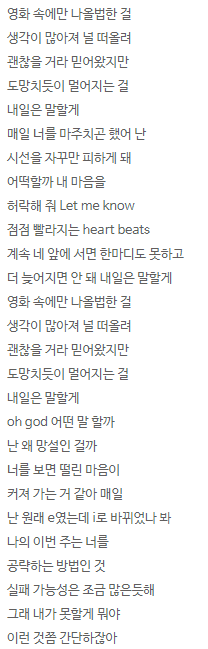

In [27]:
tommorow = ['영화', '생각이', '괜찮을', '도망', '내일은', '매일', '시선을', '어떡할까', '허락', '점점']
for word in tommorow:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> 영화 <unk> <unk> <end> 
<start> 생각이 <unk> <end> 
<start> 괜찮을 수_없는 시간속에서 <end> 
<start> 도망 <unk> <end> 


<start> 내일은 <unk> <unk> <end> 
<start> 매일 <unk> <end> 
<start> 시선을 <unk> <end> 
<start> <unk> <unk> <end> 
<start> 허락 <unk> <end> 
<start> 점점 <unk> <end> 


all genre_임수-goood  
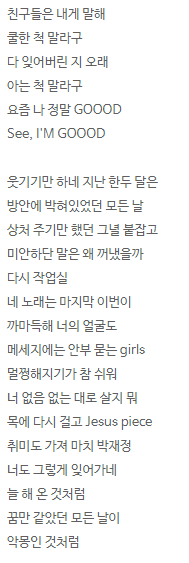

In [28]:
goood = ['친구들은', '쿨한', '다', '아는', '요즘', 'see', '웃기기만', '방안에', '상처', '미안하단']
for word in goood:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> 친구들은 <unk> <end> 
<start> <unk> <unk> <end> 
<start> 다 <unk> <end> 
<start> 아는 <unk> <unk> <unk> <end> 
<start> 요즘 <unk> <unk> <end> 
<start> see you re you do <end> 
<start> <unk> <unk> <end> 


<start> 방안에 <unk> <end> 
<start> 상처 <unk> <unk> <unk> <end> 
<start> 미안하단 <unk> <unk> <end> 


: 